In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error


In [ ]:
# 경로를 os.path.join()으로 수정
data_dir = os.path.join(os.getenv('HOME'), 'aiffel/kaggle_kakr_housing/data')

# train, test 데이터 경로 설정
train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')

# 데이터 로드
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# 확인 메시지 출력
print('됐어?')

print (train.shape)
print (test.shape)

display (train)
display (test)

In [ ]:
#원본 파일을 카피
train_og = train.copy()
test_og = test.copy()


In [ ]:
#훈련과 테스트 세트에서 학습을 위해서 target 을 분리
y = train['price']
train = train.drop(columns=['price'])

In [ ]:
# train 데이터 갯수 저장
train_len = len(train)
print(train_len)

# 총 데이터의 합
data = pd.concat((train, test), axis=0) 

display (data)
print(len(data))

test_id = data['id'][train_len:]  
data = data.drop(columns=['id']) 

print(data.columns)


In [ ]:
data_og = data.copy()

In [ ]:
print(data.isnull().sum())  # Shows missing values for each column

In [27]:
#앞에 date 6 숫자만 남기고 int로 변환 후에 다시 df로 반환 해준다 
def convert_date(df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = df['date'].apply(lambda x: int(str(x)[:6]))
    return df

In [29]:
data = convert_date(data)

print (data)

        date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0     201410         3       1.00         1180      5650     1.0           0   
1     201502         2       1.00          770     10000     1.0           0   
2     201502         3       2.00         1680      8080     1.0           0   
3     201406         3       2.25         1715      6819     2.0           0   
4     201501         3       1.50         1060      9711     1.0           0   
...      ...       ...        ...          ...       ...     ...         ...   
6463  201406         3       1.75         1500     11968     1.0           0   
6464  201501         3       2.00         1490      1126     3.0           0   
6465  201502         3       2.50         1310      1294     2.0           0   
6466  201406         2       0.75         1020      1350     2.0           0   
6467  201501         3       2.50         1600      2388     2.0           0   

      view  condition  grade  sqft_abov

In [31]:
data_og = data.copy()

print (data_og)

        date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0     201410         3       1.00         1180      5650     1.0           0   
1     201502         2       1.00          770     10000     1.0           0   
2     201502         3       2.00         1680      8080     1.0           0   
3     201406         3       2.25         1715      6819     2.0           0   
4     201501         3       1.50         1060      9711     1.0           0   
...      ...       ...        ...          ...       ...     ...         ...   
6463  201406         3       1.75         1500     11968     1.0           0   
6464  201501         3       2.00         1490      1126     3.0           0   
6465  201502         3       2.50         1310      1294     2.0           0   
6466  201406         2       0.75         1020      1350     2.0           0   
6467  201501         3       2.50         1600      2388     2.0           0   

      view  condition  grade  sqft_abov

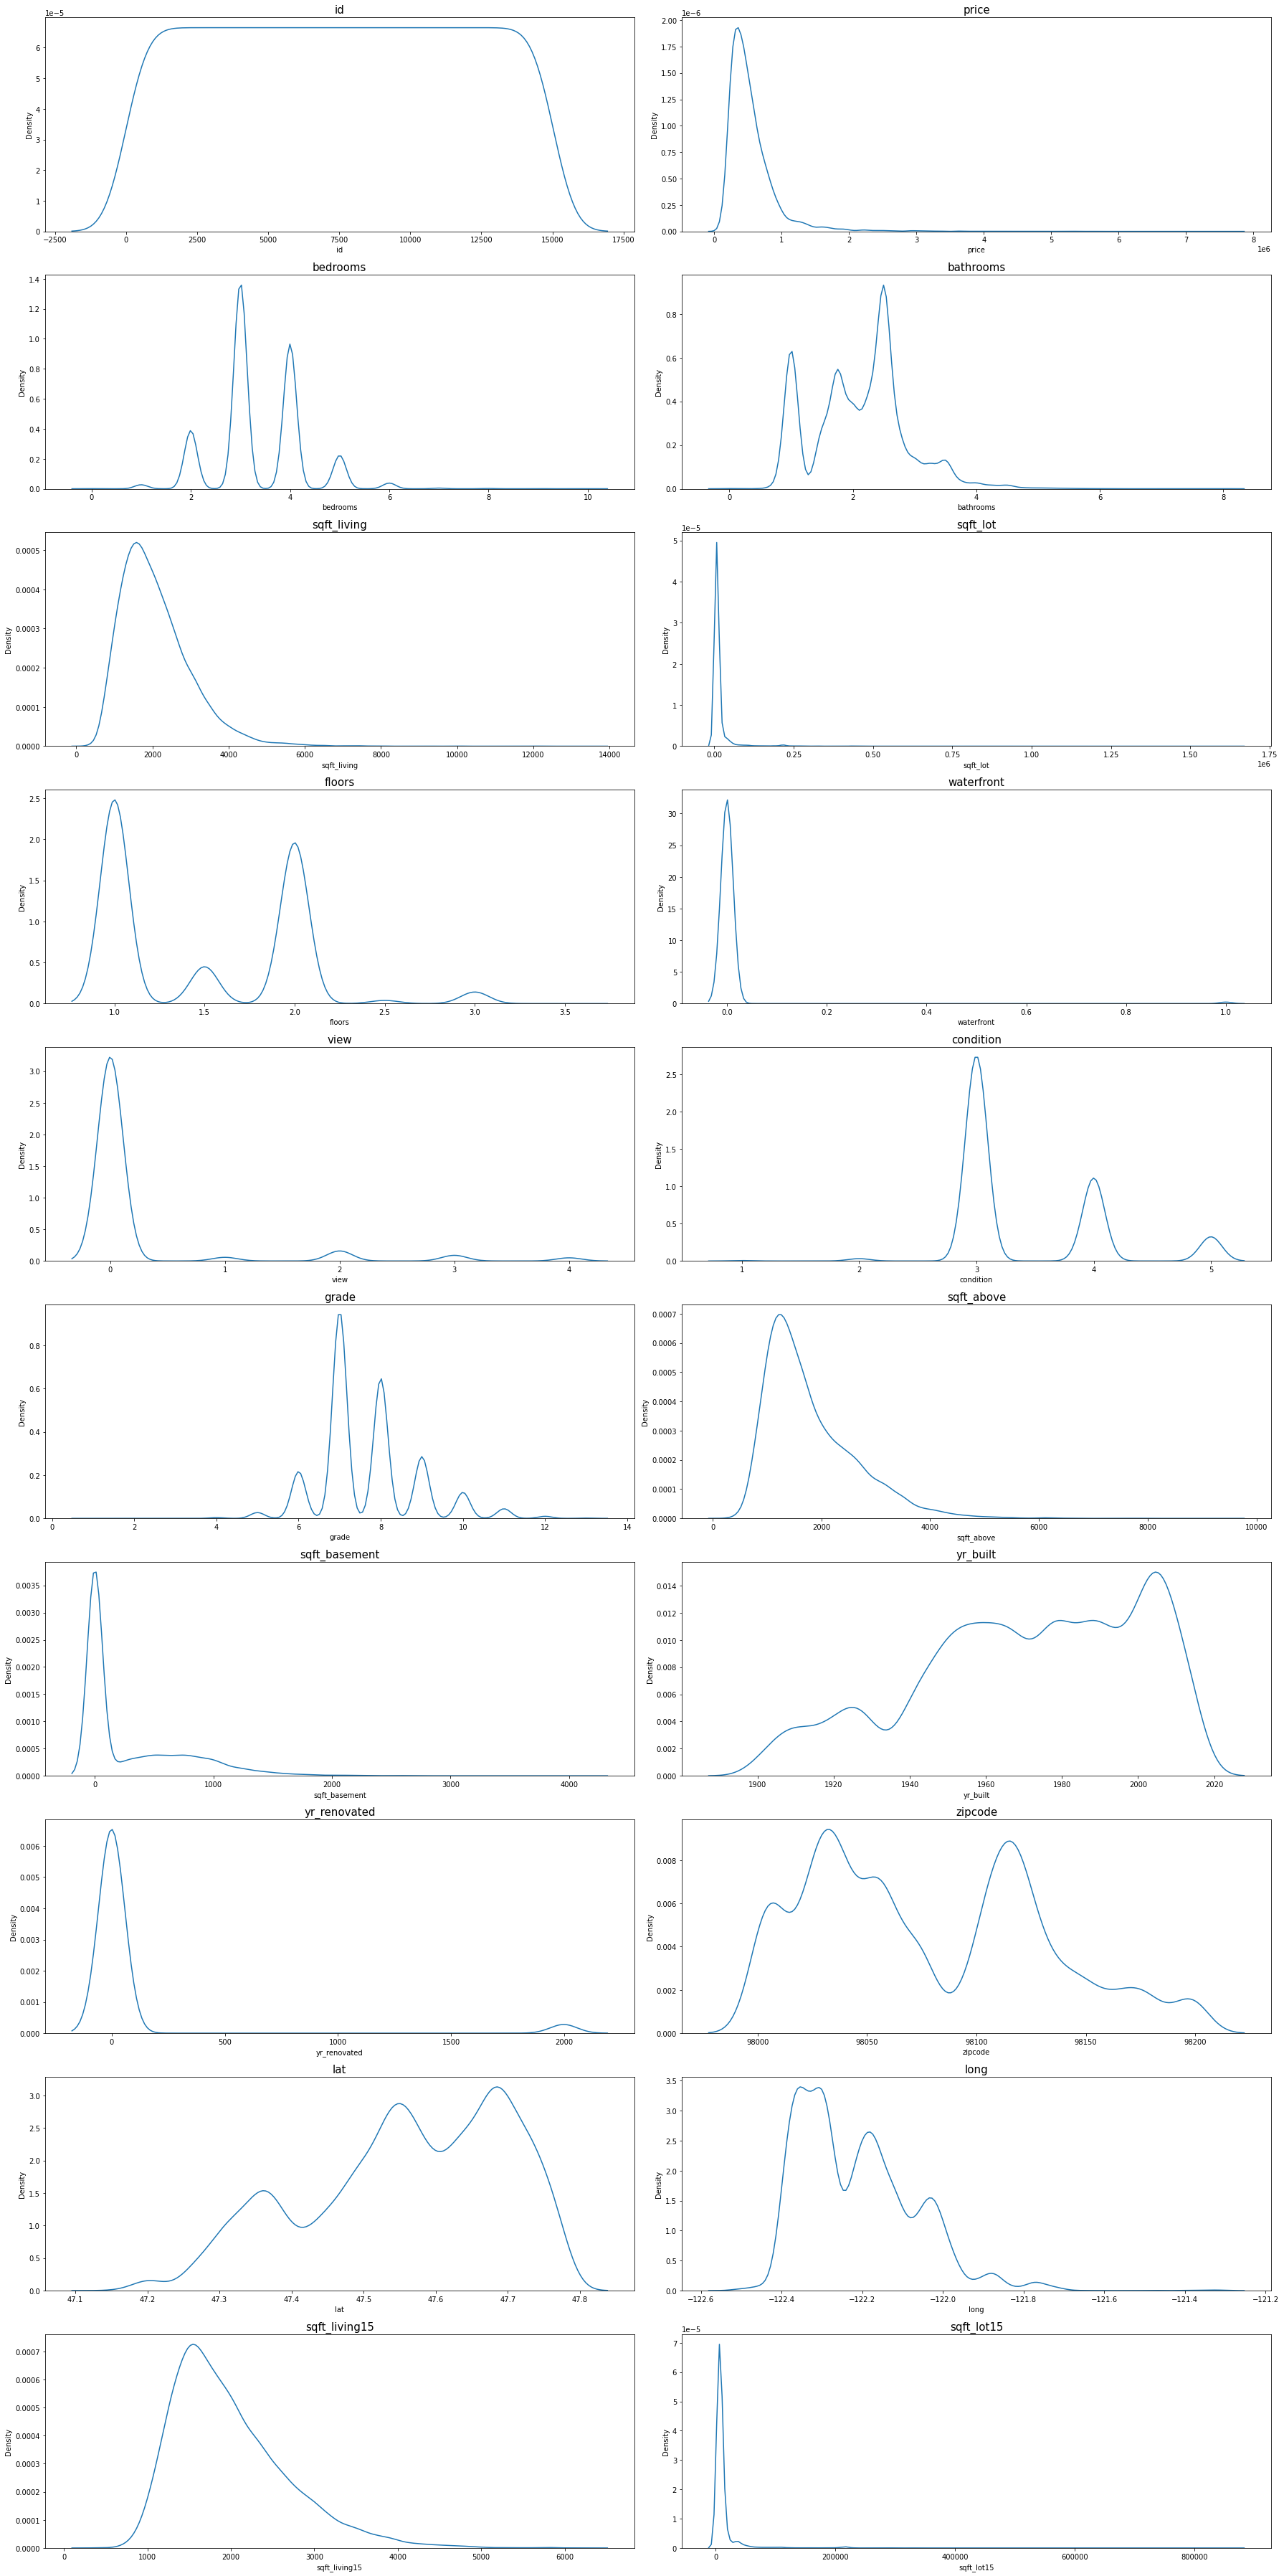

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# KDE Plot을 그리는 함수
def plot_kde_grid(data, rows=10, cols=2, figsize=(12, 50), columns=None):
    fig, ax = plt.subplots(rows, cols, figsize=figsize)  # 10행 2열의 서브플롯
    ax = ax.flatten()  # 2D 배열을 1D로 변환 (IndexError 방지)
    
    if columns is None:
        columns = data.columns[1:rows * cols + 1]  # 첫 번째 id 컬럼 제외하고 19개 선택
    
    for count, column in enumerate(columns):
        try:
            sns.kdeplot(data=data[column], ax=ax[count])
            ax[count].set_title(column, fontsize=15)
        except IndexError:
            break

    plt.tight_layout()  # 그래프 간격 자동 조정
    plt.show()

# 데이터 로드 
train = pd.read_csv(train_data_path)

# 사용 예시
plot_columns = train.columns.drop(['date'])  # 'date' 컬럼 제외
plot_kde_grid(train, 10, 2, (25, 50), plot_columns)


In [44]:
#data skeweness 확인 

# 데이터의 왜도 계산
skew_values = data.skew().sort_values(ascending=False)

print (skew_values)

sqft_lot         13.063414
waterfront       11.355434
sqft_lot15        9.509190
yr_renovated      4.539105
view              3.392064
bedrooms          1.983385
sqft_basement     1.576345
sqft_living       1.471414
sqft_above        1.446008
sqft_living15     1.106594
condition         1.036647
long              0.884048
grade             0.770530
date              0.764380
floors            0.613499
bathrooms         0.510653
zipcode           0.407406
yr_built         -0.471730
lat              -0.486830
dtype: float64


In [45]:
skewness = data.columns[abs(data.skew()) > 1]
print(skewness)

Index(['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view',
       'condition', 'sqft_above', 'sqft_basement', 'yr_renovated',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


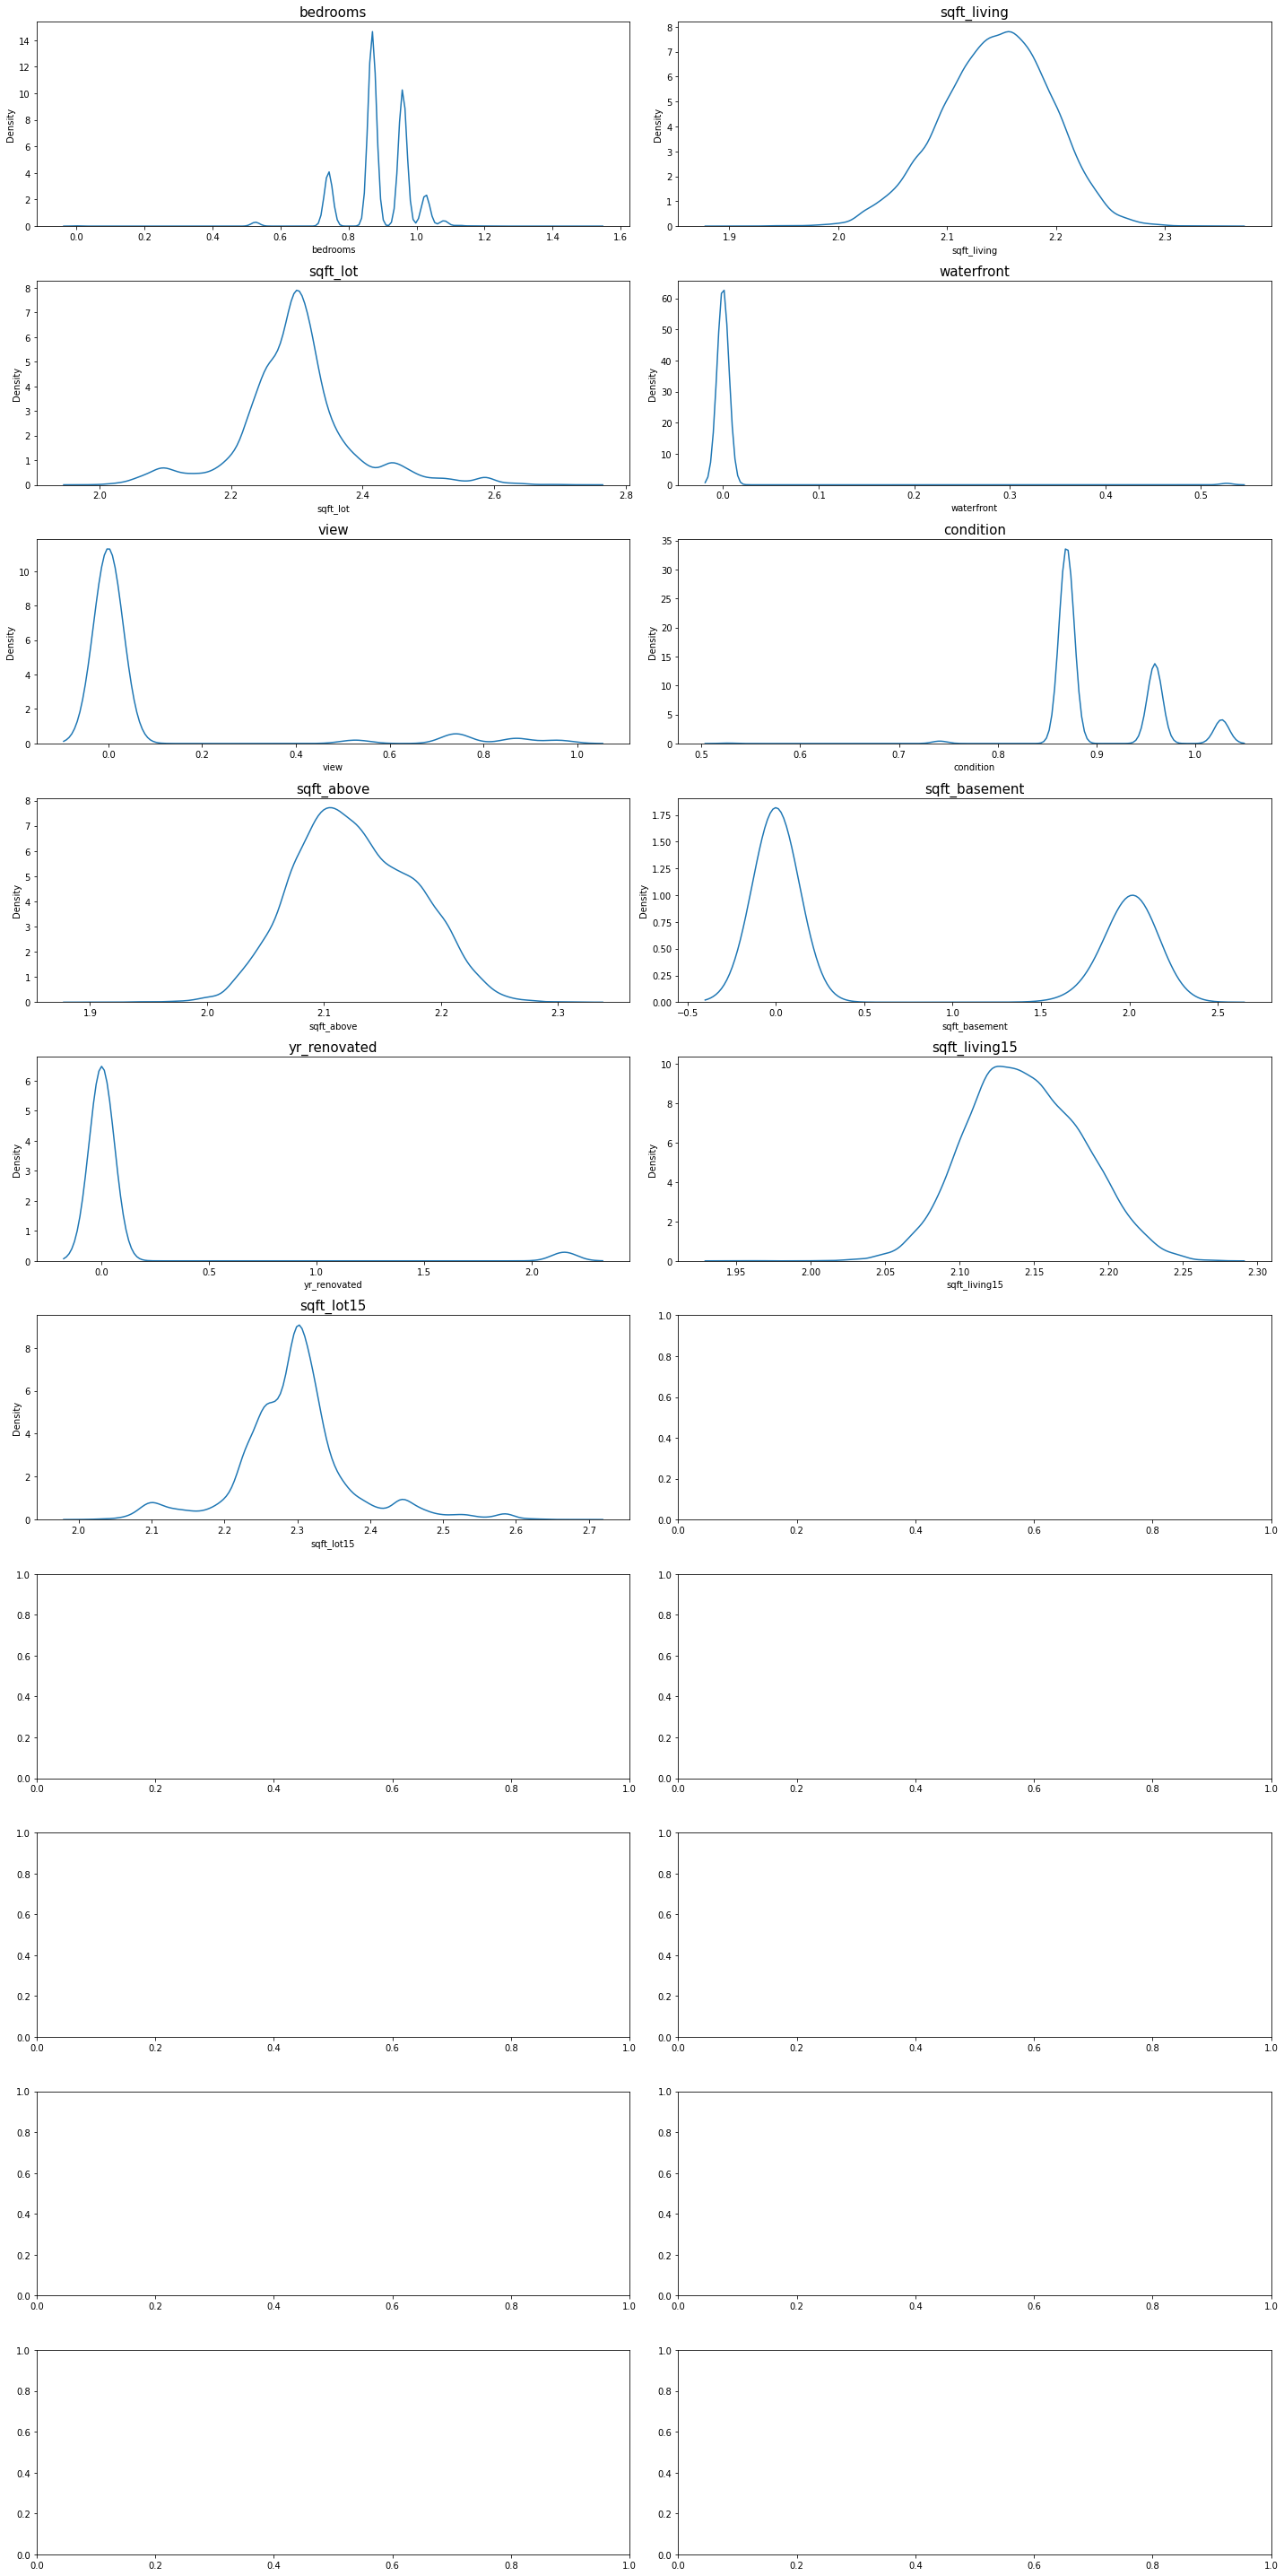

In [51]:

def log_transform(df: pd.DataFrame, skewness: list):
    for column in skewness:
        df[column] = np.log1p(df[column].values)
    return df

# 로그 변환
data = log_transform(data, skewness)

#  plot를 만들어서 확인
plot_kde_grid(data, 10, 2, (20,40), skewness)

In [54]:
skewness = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_lot15', 'sqft_living15']

In [55]:
data = log_transform(data_og, skewness)

In [ ]:
print (data)
display (data.shape)

data1= data.copy()

In [ ]:
plot_kde_grid(data, 3, 2, (25, 50), skewness)

In [ ]:
sns.kdeplot(y)
plt.show()

#로그 변환 
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [ ]:
train = data.to_numpy()[:train_len, :]
test = data.to_numpy()[train_len:, :]

print(train.shape)
print(test.shape)

In [ ]:
#필요한 모델 라이브러리에서 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

In [ ]:
# data 결측값 확인
msno.matrix(data)

In [ ]:
random_state = 2020

models = {
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=100),
    "LightGBM": LGBMRegressor(random_state=2023),
    "RandomForest": RandomForestRegressor(random_state=7)
}

def rmse(y_true, y_pred):
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)  # Reverse log transformation
    return np.sqrt(mean_squared_error(y_true, y_pred))

def scores(models, train, y):
    df = {}

    for model_name, model in models.items():  # ✅ Corrected the loop
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=45)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)

    # Convert dictionary to DataFrame after all models are evaluated
    score_df = pd.DataFrame.from_dict(df, orient='index', columns=['RMSE']).sort_values('RMSE', ascending=False)
    
    return score_df

In [ ]:
# 하이퍼 파라미터 튜닝 전 성능 확인
scores(models, train, y)

In [ ]:
def scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=45)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)

    return pd.DataFrame(df, index=["RMSE"]).T.sort_values("RMSE", ascending=False)

In [92]:
gboost_1= GradientBoostingRegressor(random_state=random_state, learning_rate= 0.1, max_depth= 5, n_estimators= 500)
xgboost_1 = XGBRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
lightgbm_1 = LGBMRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
rdforest_1 = RandomForestRegressor(random_state=random_state, max_depth=10, n_estimators=500)

models_gbt = [gboost_1]
models_xgb = [xgboost_1]
models_lgm = [lightgbm_1]
models_rdf = [rdforest_1]

scores(models_gbt, train, y)
scores(models_xgb, train, y)
scores(models_lgm, train, y)
scores(models_rdf, train, y)

,RMSE
RandomForestRegressor,157671.523887


In [107]:
import pandas as pd

def preprocessing(train_og, test_og):
    train = train_og.copy()
    test = test_og.copy()

    # 컬럼명 소문자로 변환
    train.columns = train.columns.str.lower()
    test.columns = test.columns.str.lower()

    # ✅ 'date' 컬럼 변환: 앞 6자리(YYYYMM)만 남기고 int로 변환
    if "date" in train.columns:
        train["date"] = train["date"].astype(str).str[:6].astype(int)
    if "date" in test.columns:
        test["date"] = test["date"].astype(str).str[:6].astype(int)

    # ✅ 예외 처리: 필요한 컬럼이 없을 경우 오류 발생
    if "price" not in train.columns:
        raise KeyError("Error: 'price' column not found in train dataset.")
    if "zipcode" not in train.columns:
        raise KeyError("Error: 'zipcode' column not found in train dataset.")

    # ✅ 먼저 'zipcode'별 평균 가격을 구한 후, 'price'를 제거
    zipcode_price = train.groupby("zipcode")["price"].mean()

    # 종속 변수 (target) 분리
    target = train.pop("price")  

    # train과 test 데이터에 zipcode 평균 가격 적용
    train["zipcode_price"] = train["zipcode"].map(zipcode_price)
    test["zipcode_price"] = test["zipcode"].map(zipcode_price)

    return train, test, target  # 정리된 데이터 반환

# 전처리 실행
train, test, y = preprocessing(train_og, test_og)

# 결과 확인
print(train.head())
print(test.head())


   id    date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0   0  201410         3       1.00         1180      5650     1.0           0   
1   1  201502         2       1.00          770     10000     1.0           0   
2   2  201502         3       2.00         1680      8080     1.0           0   
3   3  201406         3       2.25         1715      6819     2.0           0   
4   4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  ...  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3  ...        1180              0      1955             0   
1     0          3  ...         770              0      1933             0   
2     0          3  ...        1680              0      1987             0   
3     0          3  ...        1715              0      1995             0   
4     0          3  ...        1060              0      1963             0   

   zipcode      lat     long  sqft_living15 

In [ ]:
train, test, y = preprocessing(train_og, test_og)

In [ ]:
train['price'] = y

In [ ]:
zipcode_price = train.groupby("zipcode")["price"].mean()
train["zipcode_price"] = train["zipcode"].map(zipcode_price)

In [ ]:
train.drop(columns=['price'],inplace=True)
train.head()

In [ ]:
test["zipcode_price"] = test["zipcode"].map(zipcode_price)

In [ ]:
test.head()

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 경로를 os.path.join()으로 수정
data_dir = os.path.join(os.getenv('HOME'), 'aiffel/kaggle_kakr_housing/data')

# train, test 데이터 경로 설정
train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')

# 데이터 로드
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# 훈련과 테스트 세트에서 학습을 위해서 target 을 분리
y = train['price']
train = train.drop(columns=['price'])

# train 데이터 갯수 저장
train_len = len(train)

# 총 데이터의 합
data = pd.concat((train, test), axis=0)

# 테스트 id 저장 후 제거
test_id = data['id'][train_len:]
data = data.drop(columns=['id'])

# date 컬럼 처리
def convert_date(df: pd.DataFrame) -> pd.DataFrame:
    df['date'] = df['date'].apply(lambda x: int(str(x)[:6]))
    return df

data = convert_date(data)

# 새로운 특징 생성
data['total_sqft'] = data['sqft_living'] + data['sqft_basement'].fillna(0) + data['sqft_above'] + data['sqft_lot'] + data['sqft_living15'] + data['sqft_lot15']
data['age'] = data['yr_sold'] - data['yr_built']
data['age_renovated'] = data['yr_sold'] - data['yr_renovated'].replace(0, data['yr_built']) # 리모델링 안된 경우 건축년도 사용
data['basement_finished_ratio'] = data['sqft_basement'].fillna(0) / data['total_sqft']
data['living_lot_ratio'] = data['sqft_living'] / data['sqft_lot']

# 불필요한 컬럼 제거 (feature importance 분석 후 추가/제거 가능)
cols_to_drop = ['zipcode', 'lat', 'long', 'yr_built', 'yr_renovated', 'yr_sold', 'sqft_basement']
data = data.drop(columns=cols_to_drop, errors='ignore')

# 범주형 특징 처리 (원-핫 인코딩)
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, dummy_na=False)

# 왜도 처리 (로그 변환)
skewness_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_lot15', 'sqft_living15', 'total_sqft']
for col in skewness_cols:
    if col in data.columns:
        data[col] = np.log1p(data[col])

# 데이터 분리
train = data[:train_len]
test = data[train_len:]

# 타겟 변수 로그 변환 (이상치 처리 및 분포 개선)
y = np.log1p(y)

# 이상치 제거 (간단한 IQR 방법 - 필요에 따라 조정)
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_indices = y[(y < lower_bound) | (y > upper_bound)].index
train = train.drop(outlier_indices)
y = y.drop(outlier_indices)

# 모델 정의 및 파이프라인 구성 (스케일링 포함)
models = {
    "XGBoost": Pipeline(),
    "LightGBM": Pipeline()
}

# 하이퍼파라미터 그리드 (더 넓은 범위와 세밀한 조정을 시도해볼 수 있습니다.)
param_grids = {
    "XGBoost": {
        'model__n_estimators': ,
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [1, 2, 3],
        'model__subsample': [0.7, 0.8],
        'model__colsample_bytree': [0.7, 0.8]
    },
    "LightGBM": {
        'model__n_estimators': ,
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [1, 2, 3],
        'model__num_leaves': 
    }
}

# 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 모델별로 그리드 검색 수행
best_models = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    grid_search.fit(train, y)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    best_models[name] = grid_search.best_estimator_

# 앙상블 예측 (가중 평균 - 가중치는 필요에 따라 조정)
def ensemble_predict(models, weights, data):
    predictions = np.zeros(len(data))
    for name, model in models.items():
        predictions += weights[name] * model.predict(data)
    return predictions

weights = {"XGBoost": 0.6, "LightGBM": 0.4} # 예시 가중치
ensemble_predictions_train = ensemble_predict(best_models, weights, train)
ensemble_predictions_test = ensemble_predict(best_models, weights, test)

# 결과 평가 (훈련 데이터에 대한 RMSE)
def rmse(y_true, y_pred):
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)
    return np.sqrt(mean_squared_error(y_true_exp, y_pred_exp))

train_rmse = rmse(y, ensemble_predictions_train)
print(f"Ensemble RMSE on training data: {train_rmse}")

# 예측 결과 저장
submission = pd.DataFrame({'id': test_id, 'price': np.expm1(ensemble_predictions_test)})
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")